In [30]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os
import sys
import plotly.graph_objects as go 
from scipy.optimize import curve_fit
from scipy.stats import norm
dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')
from labbiofisica import Interpolazione, final_val

In [31]:
fondo = pd.read_csv(dir_path + '\\data\\fondo_rana.csv')
asse_maggiore = pd.read_csv(dir_path + '\\data\\red_cell_asse_maggiore_1.csv')
asse_minore = pd.read_csv(dir_path + '\\data\\red_cell_asse_minore_1.csv')

In [32]:
# FONDO
FONDO_RANA = fondo['Gray_Value'].to_numpy().mean()
FONDO_RANA_STD = fondo['Gray_Value'].to_numpy().std()

print(f'Fondo rana: {final_val(FONDO_RANA, FONDO_RANA_STD, udm=' su 256')}')

Fondo rana: 154.28 ± 3.84  su 256


In [33]:
# FUNZIONE DI INTERPOLAZIONE PER CELLULA + NUCLEO, NOTO IL FONDO

def step_function(x,mu,L):
    return np.where(np.abs(x - mu) < L/2, 1, 0)
    
def f_cell_nucleo_step(x, mu, A, B, sigmaA, sigmaB):
    return FONDO_RANA + A * step_function(x, mu, sigmaA) + B * step_function(x, mu, sigmaB)
    
def f_cell_nucleo_gauss(x, mu, A, B, sigmaA, sigmaB):
    return FONDO_RANA + norm.pdf(x, mu, sigmaA) * A + norm.pdf(x, mu, sigmaB) * B

def f_cell_nucleo_stepgauss(x, mu, A, B, sigmaA, sigmaB):
    return FONDO_RANA + A * step_function(x, mu, sigmaA) + norm.pdf(x, mu, sigmaB) * B

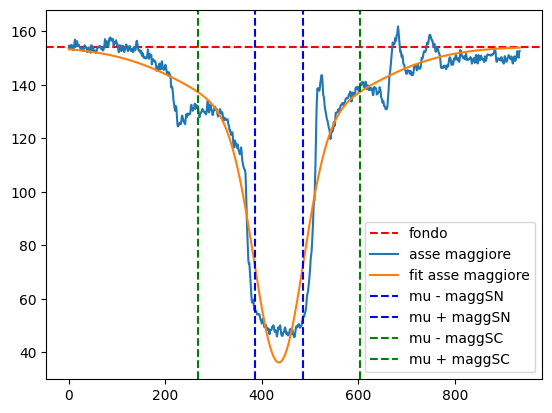

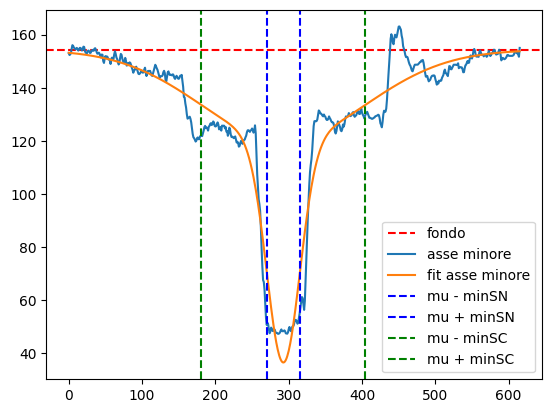

In [40]:
# ASSE MAGGIORE
ASSE_MAGGIORE = asse_maggiore['Gray_Value'].to_numpy()
ASSE_MINORE = asse_minore['Gray_Value'].to_numpy()

xmagg = asse_maggiore['Distance_(pixels)'].to_numpy()
xmin = asse_minore['Distance_(pixels)'].to_numpy()

popt_magg, pcov_magg = curve_fit(f_cell_nucleo_gauss, xmagg,ASSE_MAGGIORE, p0=[430,-100, -15, 200, 500])
popt_min, pcov_min = curve_fit(f_cell_nucleo_gauss, xmin,ASSE_MINORE, p0=[300,-100, -15, 50, 250])
names_magg = ['mu', 'maggN', 'maggC', 'maggSN', 'maggSC']
names_min = ['mu', 'minN', 'minC', 'minSN', 'minSC']

results_magg = pd.DataFrame(popt_magg, index=names_magg, columns=['values'])
results_magg['errors'] = np.sqrt(np.diag(pcov_magg))

results_min = pd.DataFrame(popt_min, index=names_min, columns=['values'])
results_min['errors'] = np.sqrt(np.diag(pcov_min))


plt.figure()
plt.axhline(y=FONDO_RANA, color='r', linestyle='--', label='fondo')
plt.plot(xmagg, ASSE_MAGGIORE, label='asse maggiore')
plt.plot(xmagg, f_cell_nucleo_gauss(xmagg, *popt_magg), label='fit asse maggiore')
plt.axvline(x=popt_magg[0] - popt_magg[3], color='b', linestyle='--', label='mu - maggSN')
plt.axvline(x=popt_magg[0] + popt_magg[3], color='b', linestyle='--', label='mu + maggSN')
plt.axvline(x=popt_magg[0] - popt_magg[4], color='g', linestyle='--', label='mu - maggSC')
plt.axvline(x=popt_magg[0] + popt_magg[4], color='g', linestyle='--', label='mu + maggSC')
plt.legend()
plt.show()

plt.figure()
plt.axhline(y=FONDO_RANA, color='r', linestyle='--', label='fondo')
plt.plot(xmin, ASSE_MINORE, label='asse minore')
plt.plot(xmin, f_cell_nucleo_gauss(xmin, *popt_min), label='fit asse minore')
plt.axvline(x=popt_min[0] - popt_min[3], color='b', linestyle='--', label='mu - minSN')
plt.axvline(x=popt_min[0] + popt_min[3], color='b', linestyle='--', label='mu + minSN')
plt.axvline(x=popt_min[0] - popt_min[4], color='g', linestyle='--', label='mu - minSC')
plt.axvline(x=popt_min[0] + popt_min[4], color='g', linestyle='--', label='mu + minSC')
plt.legend()
plt.show()

In [35]:
display(results_magg, results_min)

,values,errors
mu,435.183164,0.613132
maggN,-11493.714072,431.247348
maggC,-11455.869359,419.266459
maggSN,167.912700,6.798337
maggSC,50.366386,1.108085


,values,errors
mu,292.679367,0.413792
minN,-9589.690695,215.917325
minC,-4687.367412,155.312069
minSN,111.936106,3.185489
minSC,22.378712,0.577002


In [36]:
ratio_citoplasma = results_min.loc['minSC', 'values'] / results_magg.loc['maggSC', 'values']
sigma_ratio_citoplasma = ratio_citoplasma * np.sqrt((results_min.loc['minSC', 'errors'] / results_min.loc['minSC', 'values'])**2 + (results_magg.loc['maggSC', 'errors'] / results_magg.loc['maggSC', 'values'])**2)
ratio_nucleo = results_min.loc['minSN', 'values'] / results_magg.loc['maggSN', 'values']
sigma_ratio_nucleo = ratio_nucleo * np.sqrt((results_min.loc['minSN', 'errors'] / results_min.loc['minSN', 'values'])**2 + (results_magg.loc['maggSN', 'errors'] / results_magg.loc['maggSN', 'values'])**2)
print('Rapporto assemin/assemagg citoplasma: ',final_val(ratio_citoplasma,sigma_ratio_citoplasma, udm='μm'))
print('Rapporto assemin/assemagg nucleo: ',final_val(ratio_nucleo,sigma_ratio_nucleo, udm='μm'))

Rapporto assemin/assemagg citoplasma:  0.44 ± 0.02 μm
Rapporto assemin/assemagg nucleo:  0.67 ± 0.03 μm
